# Patient Model: Diagnostis Classification

In [1]:
%cd ..

/home/julien/Desktop/PDM/GitHub/DeepBreath-disease-Julien/src


In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import join

from config import SEED, pipeline_config

# Set random seeds and deterministic pytorch for reproducibility
random.seed(SEED)       # python random seed
np.random.seed(SEED) # numpy random seed

%matplotlib inline

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [4]:
classes = ["Control", "Bact. Pneumonia", "Viral Pneumonia", "Obst. Bronchitis", "Asthma", "Bronchiolitis"]
n_classes = len(classes)
patient_df = pd.read_csv("../data/patient_df.csv")
train_loc = pipeline_config["train_loc"]

In [5]:
patient_df

,patient,location,fold,diagnosis,old_diagnosis,all_diagnoses,multilabel
0,Pn_GVA_Co1,GVA,4,0,0,[0],False
1,Pn_GVA_Co2,GVA,0,0,0,[0],False
2,Pn_GVA_Co3,GVA,1,0,0,[0],False
3,Pn_GVA_Co4,GVA,2,0,0,[0],False
4,Pn_GVA_Co5,GVA,3,0,0,[0],False
...,...,...,...,...,...,...,...
588,Pn_RBA_Ca27,RBA,4,4,-1,[4],False
589,Pn_RBA_Ca28,RBA,0,4,-1,[4],False
590,Pn_RBA_Ca33,RBA,1,4,-1,[4],False
591,Pn_RBA_Ca34,RBA,2,4,-1,[4],False


In [6]:
exclude = []
patient_df = patient_df[~patient_df.diagnosis.isin(exclude)].reset_index(drop=True)

In [7]:
#train_loc = ["GVA", "POA"] 
#train_loc = ["GVA", "POA", "RBA", "YAO"] 
#exclude = []
#folds = [(0,1), (1,2), (2,3), (3,4), (4,0)]
#sample_network = "dense"
#output_file = "../out/aggregate/{}_agg_D{}_V{}_T{}.csv"
#output_file = "../features/{}_outputs_D{}_V{}_T{}.npy"

In [8]:
def experiment(model):
    meta = []
    for fold_1, fold_2 in pipeline_config["cv_folds"]: # pipeline_config["cv_folds"] [(0, 1), (1, 2), (2, 3), (3, 4), (4, 0)]
        print('#'*25, f"FOLD {fold_1}-{fold_2}", '#'*25) 
        test_meta_1 = multi_class(model, val_fold=fold_1, test_fold=fold_2)
        print()
        print('#'*25, f"FOLD {fold_2}-{fold_1}", '#'*25)
        test_meta_2 = multi_class(model, val_fold=fold_2, test_fold=fold_1)
        meta += [test_meta_1, test_meta_2]
        print()
       
    internal_meta, external_meta = post_process_predictions(meta)
    return internal_meta, external_meta

In [9]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=1)[:, np.newaxis]


def normalize_prob(x):
    out = x / np.sum(x, axis=1)[:, np.newaxis]
    return out

In [10]:
targets = [[0], [1,2], [3,4], [5]]
#targets = [[idx for idx in ls if not idx in pipeline_config["exclude"]] for ls in all_targets]

def multi_class(model, val_fold, test_fold, targets=targets):
    codes = {d: i for i, t in enumerate(targets) for d in t}
    
    position_df = patient_df.copy()
    
    loc_selection = (position_df.location.isin(train_loc)).values
    val_indices = (position_df.fold == val_fold).values & loc_selection
    test_indices = (position_df.fold == test_fold).values | (~loc_selection)

    position_df = position_df.assign(set="train")
    position_df.loc[val_indices, "set"] = "val"
    position_df.loc[test_indices, "set"] = "test"
    
    merged_output_df = None
    output_cols = []
    
    for target in targets:
        target_str = '+'.join([str(t) for t in target])
        
        df_dir = join(pipeline_config["out_folder"], "aggregate")
        output_df_file = join(df_dir,
                              pipeline_config["aggregate_file"].format(pipeline_config["network"]["feature_model"], target_str, val_fold, test_fold))
        output_df = pd.read_csv(output_df_file)
        
        if merged_output_df is None:
            merged_output_df = output_df
        else:
            merged_output_df = merged_output_df.merge(output_df, on=["patient", "position"])
            
        output_cols.append(f"output_{target_str}")
        
    #return merged_output_df
        
    merged_output_df[output_cols] = normalize_prob(merged_output_df[output_cols].values)
    position_df = position_df.merge(merged_output_df, on="patient")
    
    patient_preds, patient_meta = mean_output_dataset(position_df, output_cols)
    patient_meta = patient_meta.assign(label=patient_meta.diagnosis.apply(lambda d: codes[d]))
    
    #return patient_preds, patient_meta
    
    test_meta = multi_fit(model, patient_preds, patient_meta, targets)
    
    return test_meta

In [11]:
def mean_output_dataset(position_df, output_cols):
    all_preds = position_df.pivot(index="patient", columns="position", values=output_cols).dropna()
    patient_meta = position_df.drop(columns=["position"]+output_cols).drop_duplicates()
    patient_meta = patient_meta.set_index("patient").loc[all_preds.index.values]

    return all_preds, patient_meta

In [12]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV


def hyperparameter_tuning(X_train, y_train, train_meta):
    # Set the parameters by cross-validation
    tuned_parameters = [{
        "C": np.logspace(-3, 3, 7), 
        "penalty": ["l1", "l2"],
        "solver": ["liblinear"],
        "class_weight": ["balanced"]
    },
    {
        "C": np.logspace(-3, 3, 7), 
        "penalty": ["l2"],
        "solver": ["newton-cg", "lbfgs"],
        "class_weight": ["balanced"]
    }]
    
    cv = StratifiedKFold(n_splits=4)
    cv_list = [(train_idx, test_idx) for train_idx, test_idx in cv.split(X_train, train_meta.diagnosis)]
    clf = GridSearchCV(LogisticRegression(), tuned_parameters, scoring="recall_macro", cv=cv_list, n_jobs=-1, error_score=0)
    clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    
    return clf

In [13]:
def multi_fit(model, patient_preds, patient_meta, targets):
    test_selection = (patient_meta.set == "test").values
    test_data, test_meta = patient_preds[test_selection], patient_meta[test_selection]
    train_data, train_meta = patient_preds[~test_selection], patient_meta[~test_selection]
    
    X_test, y_test = test_data.values, test_meta.label.values
    X_train, y_train = train_data.values, train_meta.label.values
    
    print(f"X_train shape: {X_train.shape}", f"- X_test.shape: {X_test.shape}")
    
    # add hyper-parameter tuning?
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_meta = test_meta.assign(prediction=y_pred)
    
    prob_columns = [f"probability_{i}" for i in np.unique(y_train)]
    test_meta = test_meta.assign(**{col: 0. for col in prob_columns})
        
    probs = model.predict_proba(X_test)
    test_meta[prob_columns] = np.around(probs, 3)
    
    return test_meta

In [14]:
def post_process_predictions(meta):
    internal_meta = []
    external_meta = []
    
    for meta_df in meta:
        internal_df = meta_df[meta_df.location.isin(train_loc)].reset_index()
        #internal_df = internal_df.assign(prediction=(internal_df.probability > 0.5).astype(int))
        internal_meta.append(internal_df)
        
        external_df = meta_df[~meta_df.location.isin(train_loc)].reset_index()
        external_meta.append(external_df)
    
    external_meta = pd.concat(external_meta)
    prob_columns = [f"probability_{i}" for i in np.unique(external_meta.label)]
    external_meta = external_meta.groupby(['patient', 'location', 'diagnosis', 'label'])[prob_columns].agg("mean")
    external_meta = external_meta.assign(prediction=external_meta[prob_columns].values.argmax(axis=1))
    external_meta = external_meta.reset_index()
    
    return internal_meta, external_meta

In [15]:
def compute_confusion_matrices(test_meta):
    cf_matrices = {}

    for location in test_meta.location.unique():
        selection = test_meta[test_meta.location == location]
        cf_matrices[location] = confusion_matrix(selection.label.values, selection.prediction.values, labels=range(len(targets)))
            
    return cf_matrices

In [16]:
def location_recalls(cf_matrices):
    agg_stats = {loc: np.zeros((n_classes, n_classes)) for loc, cf_m in cf_matrices[0].items()}
    for fold_stats in cf_matrices:
        for loc, cf_m in fold_stats.items():
            agg_stats[loc] += cf_m
    
    agg_df = {}
    for loc, loc_stats in agg_stats.items():
        recall_vals = np.zeros(len(loc_stats))
        for i, r in enumerate(loc_stats):
            total_samples = r.sum()
            if total_samples == 0:
                recall_vals[i] = np.nan
            else:
                recall_vals[i] = round(r[i] / total_samples, 3)
        agg_df[loc] = recall_vals

    agg_df = pd.DataFrame.from_dict(agg_df)
    agg_df.index = [f"{i}_diagnosis_recall" for i in range(len(agg_df))]
    
    return agg_df

In [17]:
def get_recalls(cf_matrix):
    class_recalls = np.zeros(n_classes)
    for i, r in enumerate(cf_matrix):
        total_samples = r.sum()
        if total_samples == 0:
            class_recalls[i] = np.nan
        else:
            class_recalls[i] = r[i] / total_samples
            
    return class_recalls


def report_stats(cf_matrices, meta):
    internal_cf = []
    external_cf = []
    
    for fold_cfs in cf_matrices:
        for loc, cf_m in fold_cfs.items():
            if loc in pipeline_config["train_loc"]:
                internal_cf.append(cf_m)
            else:
                external_cf.append(cf_m)
                
    internal_cf = np.stack(internal_cf).sum(axis=0)
    external_cf = np.stack(external_cf).sum(axis=0)
    
    meta_df = pd.concat(meta).reset_index()
    internal_patients = meta_df[meta_df.location.isin(pipeline_config["train_loc"])][["patient", "diagnosis"]].drop_duplicates()
    internal_total = internal_patients.groupby("diagnosis").size().values
    external_patients = meta_df[~meta_df.location.isin(pipeline_config["train_loc"])][["patient", "diagnosis"]].drop_duplicates()
    external_total = external_patients.groupby("diagnosis").size().values
                
    internal_recalls = get_recalls(internal_cf)
    internal_recalls = [round(100*r, 1) for r in internal_recalls]
    print('#'*10, " & ".join(pipeline_config["train_loc"]),'#'*10)
    print(pd.DataFrame.from_dict({cat: [rec, n_patients] for cat, rec, n_patients in zip(classes, internal_recalls, internal_total)}, orient="index", columns=["Recall", "N"]))
    print()
    
    external_recalls = get_recalls(external_cf)
    external_recalls = [round(100*r, 1) for r in external_recalls]
    print('#'*10, "External validation data",'#'*10)
    print(pd.DataFrame.from_dict({cat: [rec, n_patients] for cat, rec, n_patients in zip(classes, external_recalls, external_total)}, orient="index", columns=["Recall", "N"]))

### Plotting Results

In [18]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

In [19]:
fontsize = 18  # 18
titlesize = 21  # 24
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=titlesize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=titlesize)  # fontsize of the figure title

In [20]:
def get_mean_cf(cf_matrices):
    
    internal_cf = []
    
    for internal_fold_cf in cf_matrices:
        internal_fold_cf = internal_fold_cf / internal_fold_cf.sum(axis=1)[:, np.newaxis]
        internal_cf.append(internal_fold_cf)
        
    internal_cf = np.stack(internal_cf).mean(axis=0)
    
    return internal_cf

In [21]:
def plot_confusion_matrix(meta, internal=True):
    labels = ["Control", "Pneumonia", "Wheezing Dis.", "Bronchiolitis"]
    #meta_df = pd.concat(meta)
    if internal:
        cf_matrices = [confusion_matrix(meta_df.label.values, meta_df.prediction.values, labels=range(len(targets))) for meta_df in meta]
        internal_cf = get_mean_cf(cf_matrices)
        internal_cf = np.around(internal_cf, 3)
    else:
        external_cf = confusion_matrix(meta.label.values, meta.prediction.values, labels=range(len(targets)))
        external_cf = external_cf / external_cf.sum(axis=1)[:, np.newaxis]
        external_cf = np.around(external_cf, 3)
    
    if internal:
        cf = internal_cf
        fig_file = "../images/confusion_matrix_{}.png".format("in")
        title = "Internal"
        #meta_filter = meta_df.location.isin(pipeline_config["train_loc"])
        cmap = "Blues"
    else:
        cf = external_cf
        fig_file = "../images/confusion_matrix_{}.png".format("out")
        title = "External"
        #meta_filter = ~meta_df.location.isin(pipeline_config["train_loc"])
        cmap = "Greens"

    """m_selected = meta_df[meta_filter]
    cm = confusion_matrix(m_selected.label, m_selected.prediction)
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = 100 * np.around(cm_norm, 3)"""
        
    fig, ax = plt.subplots(figsize=(9,7.5))
    
    # Percentages
    sns.heatmap(cf, vmin=0., vmax=1., annot=True, fmt='g', cmap=cmap, ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    #ax2.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels, rotation=45); 
    ax.yaxis.set_ticklabels(labels, rotation=45);
    bottom, top = ax.get_ylim();
    #ax.set_title(title);
    
    # Numbers
    """sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, ax=ax2);  # cbar=False, 
    ax2.set_xlabel('Predicted labels');
    ax2.set_ylabel('True labels'); 
    #ax1.set_title('Confusion Matrix'); 
    ax2.xaxis.set_ticklabels(labels, rotation=45); 
    ax2.yaxis.set_ticklabels(labels, rotation=45);
    bottom, top = ax2.get_ylim();
    ax2.set_ylim(bottom + 0.5, top - 0.5);
    ax2.set_title("Original");"""
    
    #plt.xticks(rotation=90);
    #plt.yticks(rotation=0);
    #plt.suptitle(title, y=1.05, size=23)
    
    #plt.tight_layout()
    plt.savefig(fig_file, bbox_inches='tight')

## Multi-class Classification

In [22]:
model = LogisticRegression(random_state=0, class_weight="balanced", multi_class="multinomial")

In [23]:
internal_meta, external_meta = experiment(model)

######################### FOLD 0-1 #########################
X_train shape: (272, 32) - X_test.shape: (231, 32)

######################### FOLD 1-0 #########################
X_train shape: (264, 32) - X_test.shape: (239, 32)

######################### FOLD 0-2 #########################
X_train shape: (268, 32) - X_test.shape: (235, 32)

######################### FOLD 2-0 #########################
X_train shape: (264, 32) - X_test.shape: (239, 32)

######################### FOLD 0-3 #########################
X_train shape: (272, 32) - X_test.shape: (231, 32)

######################### FOLD 3-0 #########################
X_train shape: (264, 32) - X_test.shape: (239, 32)

######################### FOLD 0-4 #########################
X_train shape: (268, 32) - X_test.shape: (235, 32)

######################### FOLD 4-0 #########################
X_train shape: (264, 32) - X_test.shape: (239, 32)

######################### FOLD 1-2 #########################
X_train shape: (268, 32) - X_test.s

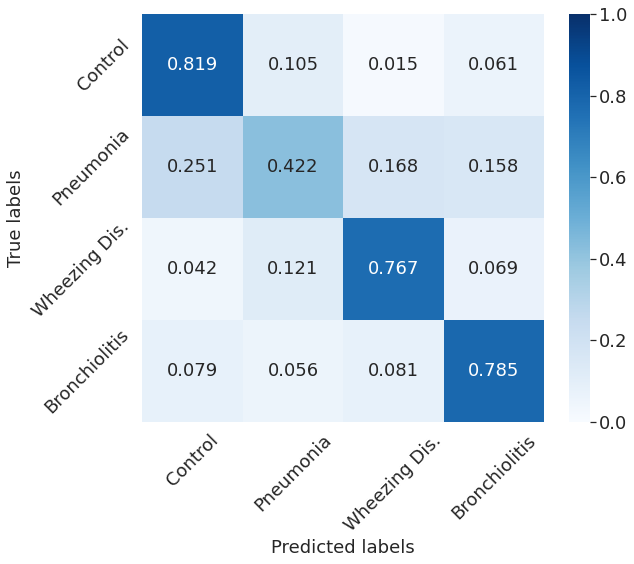

In [24]:
plot_confusion_matrix(internal_meta, internal=True)

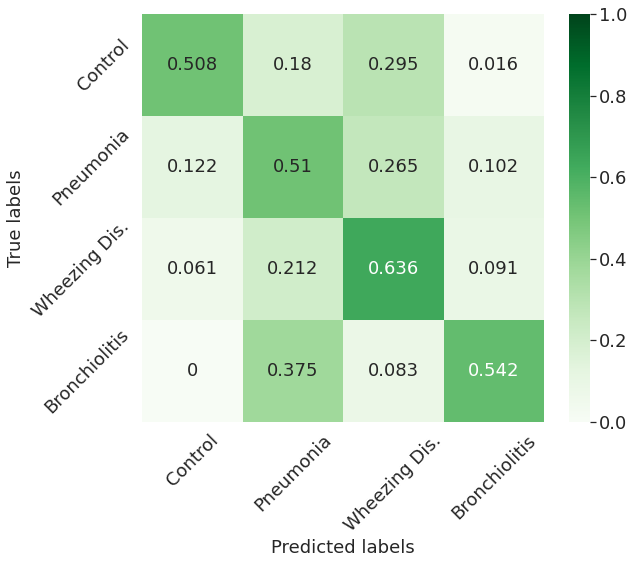

In [25]:
plot_confusion_matrix(external_meta, internal=False)

## Comparing classifiers

In [54]:
model['linearsvc'].coef_

array([[ 0.69923581,  1.0139208 ,  0.04720698,  0.48552429,  0.40424198,
         0.44292711, -0.05548497,  0.25616811]])

In [20]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "Logistic Regression"]

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Naive Bayes", "Logistic Regression"]

"""classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", class_weight="balanced"),
    SVC(class_weight="balanced"),
    DecisionTreeClassifier(max_depth=5, class_weight="balanced"),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, class_weight="balanced"),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(class_weight="balanced")]"""

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", class_weight="balanced", probability=True),
    SVC(class_weight="balanced", probability=True),
    GaussianNB(),
    LogisticRegression(class_weight="balanced")]

In [ ]:
model_cf = {}
for name, clf in zip(names, classifiers):
    print(name, "Classification")
    model = make_pipeline(clf)
    #model = make_pipeline(MinMaxScaler(), clf)
    cf_matrices, _ = experiment(model)
    #metrics = experiment(model)
    model_cf[name] = cf_matrices
    print()

In [22]:
for name, cf_matrices in model_cf.items():
    print(name)
    print(report_stats(cf_matrices))
    print()

Nearest Neighbors
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]
([0.73, 0.761, 0.95, 0.979, 0.943, 0.941], (0.73, 0.91), [0.533, 0.809, 1.0, 0.8, 0.913, 0.958], (0.533, 0.868))

Linear SVM
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]
([0.819, 0.674, 0.95, 0.966, 0.893, 0.915], (0.819, 0.87), [0.705, 0.702, 1.0, 0.7, 0.87, 0.917], (0.705, 0.792))

RBF SVM
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]
([0.804, 0.703, 1.0, 0.979, 0.902, 0.91], (0.804, 0.881), [0.68, 0.745, 1.0, 0.7, 0.848, 0.938], (0.68, 0.811))

Naive Bayes
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]
([0.819, 0.696, 1.0, 0.993, 0.902, 0.926], (0.819, 0.888), [0.689, 0.777, 1.0, 0.8, 0.891, 0.979], (0.689, 0.854))

Logistic Regression
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]
([0.828, 0.681, 0.95, 0.993, 0.877, 0.915], (0.828, 0.875), [0.697, 0.723, 1.0, 0.7, 0.87, 0.979], (0.697, 0.816))

